# Generate music with an RNN


## Setup

In [1]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple

2022-12-06 10:00:37.478897: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-06 10:00:37.666091: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-06 10:00:37.666122: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-06 10:00:37.695657: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-06 10:00:38.569131: W tensorflow/stream_executor/platform/de

In [2]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

## Download the Maestro dataset

In [3]:
data_path = pathlib.Path('data/chopin')
filenames = glob.glob(str(data_path/"*.mid"))
print('Number of files:', len(filenames))

Number of files: 37


## Process a MIDI file

In [4]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [5]:
sample_file = filenames[1]
pm = pretty_midi.PrettyMIDI(sample_file)
display_audio(pm)

fluidsynth: warning: SDL2 not initialized, SDL2 audio driver won't be usable
fluidsynth: error: Unknown integer parameter 'synth.sample-rate'


In [6]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 1
Instrument name: Acoustic Grand Piano


## Extract notes

In [7]:
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=47, note_name=B2, duration=0.3101
1: pitch=50, note_name=D3, duration=0.2917
2: pitch=71, note_name=B4, duration=0.6018
3: pitch=54, note_name=F#3, duration=0.2853
4: pitch=59, note_name=B3, duration=0.2787
5: pitch=71, note_name=B4, duration=0.5639
6: pitch=62, note_name=D4, duration=1.1658
7: pitch=66, note_name=F#4, duration=1.1658
8: pitch=71, note_name=B4, duration=0.5669
9: pitch=71, note_name=B4, duration=0.6000


In [8]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [9]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,47,0.002660,0.312749,0.00000,0.310090
1,71,0.002660,0.604496,0.00000,0.601837
2,62,0.002660,1.168421,0.00000,1.165761
3,66,0.002660,1.168421,0.00000,1.165761
4,50,0.312749,0.604496,0.31009,0.291747


In [10]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['B2', 'B4', 'D4', 'F#4', 'D3', 'F#3', 'B4', 'B3', 'B4', 'D4'],
      dtype='<U3')

In [11]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

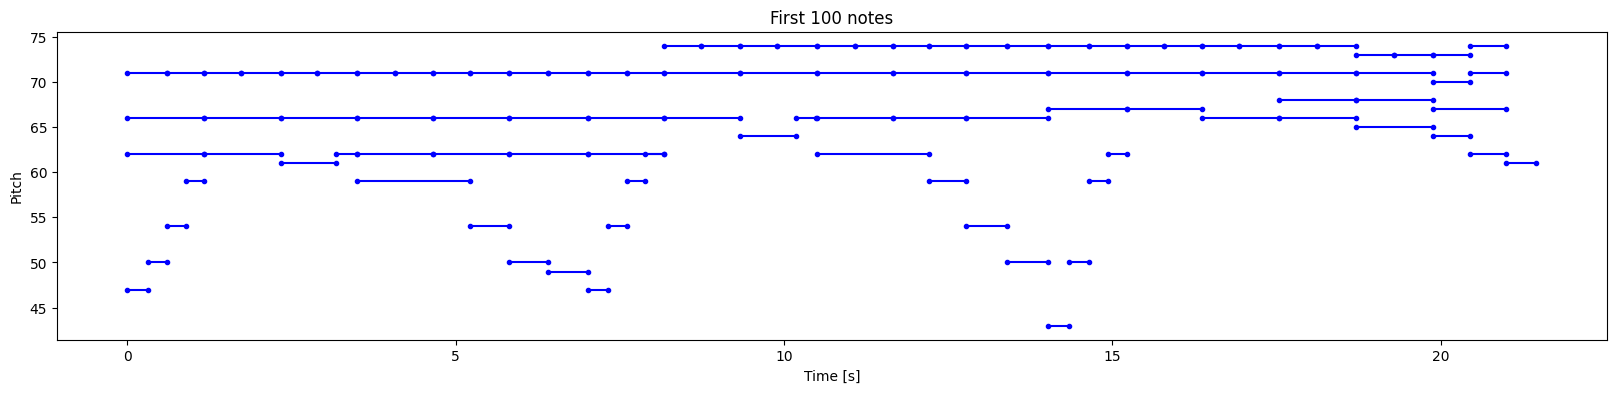

In [12]:
plot_piano_roll(raw_notes, count=100)

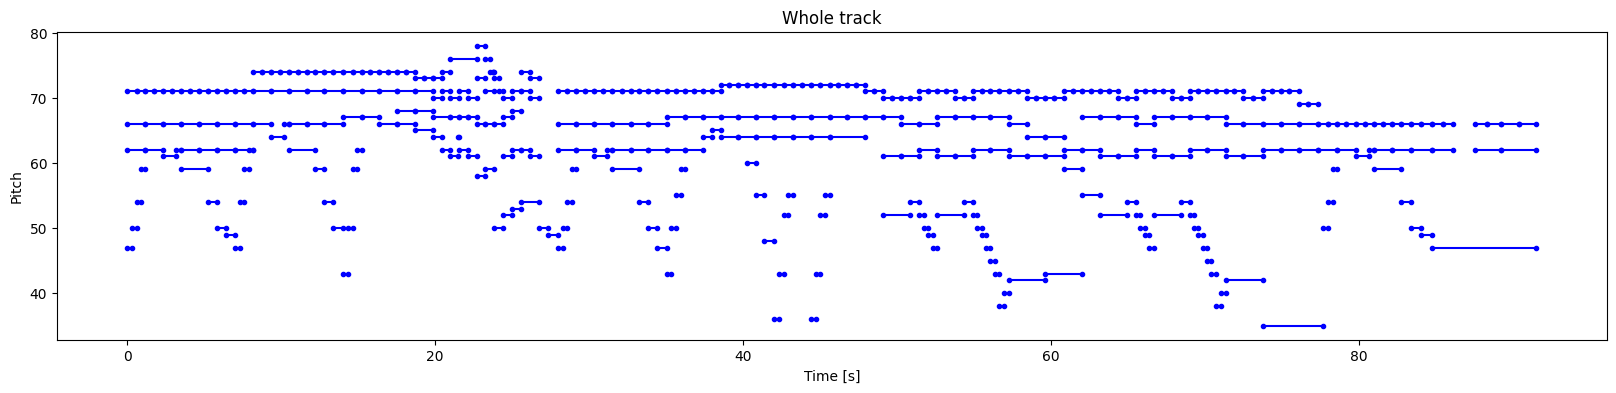

In [13]:
plot_piano_roll(raw_notes)

In [14]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

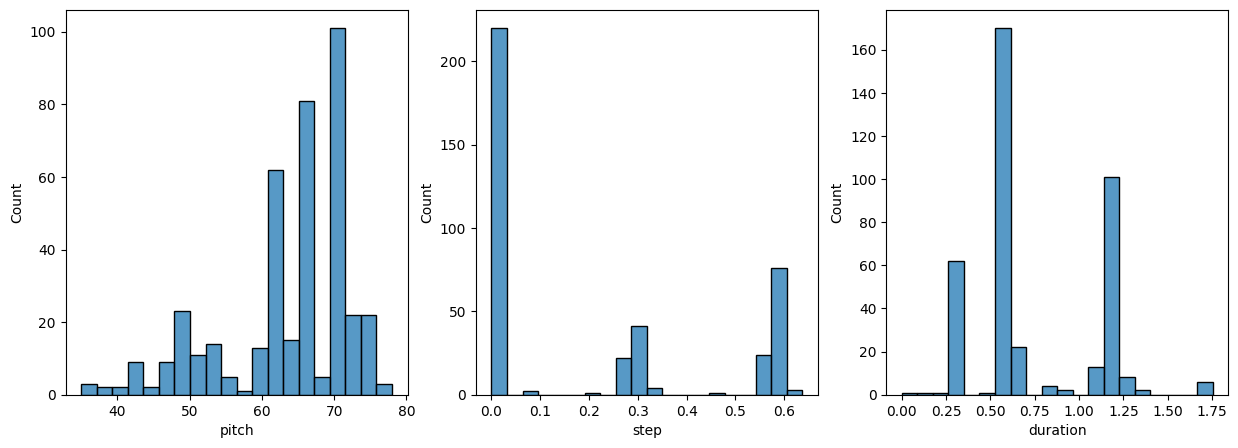

In [15]:
plot_distributions(raw_notes)

## Create a MIDI file

In [16]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [17]:
example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)

In [18]:
display_audio(example_pm)

fluidsynth: warning: SDL2 not initialized, SDL2 audio driver won't be usable
fluidsynth: error: Unknown integer parameter 'synth.sample-rate'


## Create the training dataset

In [19]:
num_files = len(filenames)
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [20]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 65873


In [21]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [22]:
train_notes

array([[ 34.        ,   0.        ,   0.3550295 ],
       [ 77.        ,   0.        ,   1.800532  ],
       [ 53.        ,   0.3550295 ,   0.29646617],
       ...,
       [ 37.        ,   0.20833325,   1.7195265 ],
       [ 25.        ,   0.        ,   1.7195265 ],
       [101.        ,   0.        ,   1.7195265 ]])

In [23]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

2022-12-06 10:00:44.936147: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-06 10:00:44.936536: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-06 10:00:44.936941: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-12-06 10:00:44.937143: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-12-06 10:00:44.937317: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [24]:
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [25]:
seq_length = 100
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(100, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [26]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (100, 3)
sequence elements (first 10): tf.Tensor(
[[0.265625   0.         0.3550295 ]
 [0.6015625  0.         1.800532  ]
 [0.4140625  0.3550295  0.29646617]
 [0.4296875  0.29646617 0.28458125]
 [0.40625    0.         0.28458125]
 [0.4453125  0.28458125 0.27896408]
 [0.3984375  0.         0.27896408]
 [0.453125   0.27896408 0.2884615 ]
 [0.390625   0.         0.2884615 ]
 [0.46875    0.2884615  0.2970295 ]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=48.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.0>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.3076924999999999>}


In [27]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [28]:
train_ds.element_spec

(TensorSpec(shape=(64, 100, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

## Create and train the model

In [29]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [30]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 3)]     0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 128)          67584       ['input_1[0][0]']                
                                                                                                  
 duration (Dense)               (None, 1)            129         ['lstm[0][0]']                   
                                                                                                  
 pitch (Dense)                  (None, 128)          16512       ['lstm[0][0]']                   
                                                                                              

In [31]:
losses = model.evaluate(train_ds, return_dict=True)
losses

2022-12-06 10:00:56.544545: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 44013 of 65773


      2/Unknown - 16s 52ms/step - loss: 5.7197 - duration_loss: 0.3936 - pitch_loss: 4.8706 - step_loss: 0.4555

2022-12-06 10:01:01.656234: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


1027/1027 [==============================] - 66s 48ms/step - loss: 5.8244 - duration_loss: 0.4989 - pitch_loss: 4.8678 - step_loss: 0.4577


{'loss': 5.824361801147461,
 'duration_loss': 0.49888744950294495,
 'pitch_loss': 4.8677592277526855,
 'step_loss': 0.4577177166938782}

In [32]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

In [33]:
model.evaluate(train_ds, return_dict=True)

1027/1027 [==============================] - 50s 48ms/step - loss: 1.2000 - duration_loss: 0.4989 - pitch_loss: 4.8678 - step_loss: 0.4577


{'loss': 1.1999945640563965,
 'duration_loss': 0.49888744950294495,
 'pitch_loss': 4.8677592277526855,
 'step_loss': 0.4577177166938782}

In [34]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [35]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50
1027/1027 [==============================] - 120s 115ms/step - loss: 0.3264 - duration_loss: 0.1047 - pitch_loss: 4.0342 - step_loss: 0.0199
Epoch 2/50
1027/1027 [==============================] - 120s 116ms/step - loss: 0.3139 - duration_loss: 0.0983 - pitch_loss: 3.9405 - step_loss: 0.0186
Epoch 3/50
1027/1027 [==============================] - 117s 114ms/step - loss: 0.3076 - duration_loss: 0.0948 - pitch_loss: 3.8898 - step_loss: 0.0182
Epoch 4/50
1027/1027 [==============================] - 112s 109ms/step - loss: 0.3010 - duration_loss: 0.0902 - pitch_loss: 3.8619 - step_loss: 0.0177
Epoch 5/50
1027/1027 [==============================] - 115s 112ms/step - loss: 0.2963 - duration_loss: 0.0864 - pitch_loss: 3.8503 - step_loss: 0.0173
Epoch 6/50
1027/1027 [==============================] - 114s 111ms/step - loss: 0.2913 - duration_loss: 0.0828 - pitch_loss: 3.8333 - step_loss: 0.0169
Epoch 7/50
1027/1027 [==============================] - 112s 110ms/step - loss: 0.2900 -

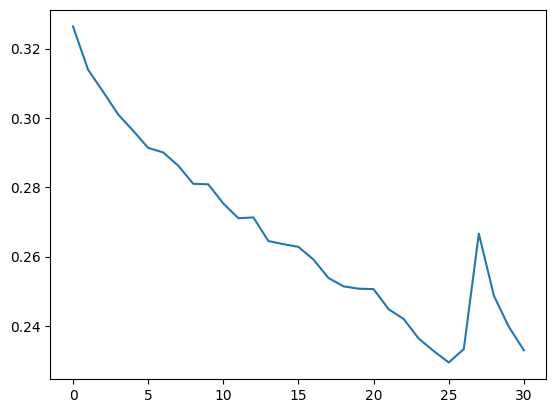

In [36]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

## Generate notes

In [38]:
def predict_next_note(
    notes: np.ndarray, 
    keras_model: tf.keras.Model, 
    temperature: float = 1.0) -> int:
  """Generates a note IDs using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

In [39]:
temperature = 2
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

1/1 [==============================] - 0s 22ms/step


In [40]:
generated_notes.head(10)

,pitch,step,duration,start,end
0,66,0.050395,0.609452,0.050395,0.659847
1,95,0.000000,1.832144,0.050395,1.882539
2,95,0.000000,1.995996,0.050395,2.046391
3,77,0.000000,2.022935,0.050395,2.073330
4,81,0.000000,2.026875,0.050395,2.077270
5,78,0.000000,2.027578,0.050395,2.077973
6,67,0.000000,2.027654,0.050395,2.078049
7,81,0.000000,2.027911,0.050395,2.078306
8,52,0.000000,2.027597,0.050395,2.077992
9,80,0.000000,2.025037,0.050395,2.075432


In [41]:
out_file = 'output_chopin_50epoch_50seqlength.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

fluidsynth: warning: SDL2 not initialized, SDL2 audio driver won't be usable
fluidsynth: error: Unknown integer parameter 'synth.sample-rate'


In [42]:
# CODE TO DOWNLOAD THE GENERATED MUSIC 
#from google.colab import files
#files.download(out_file)

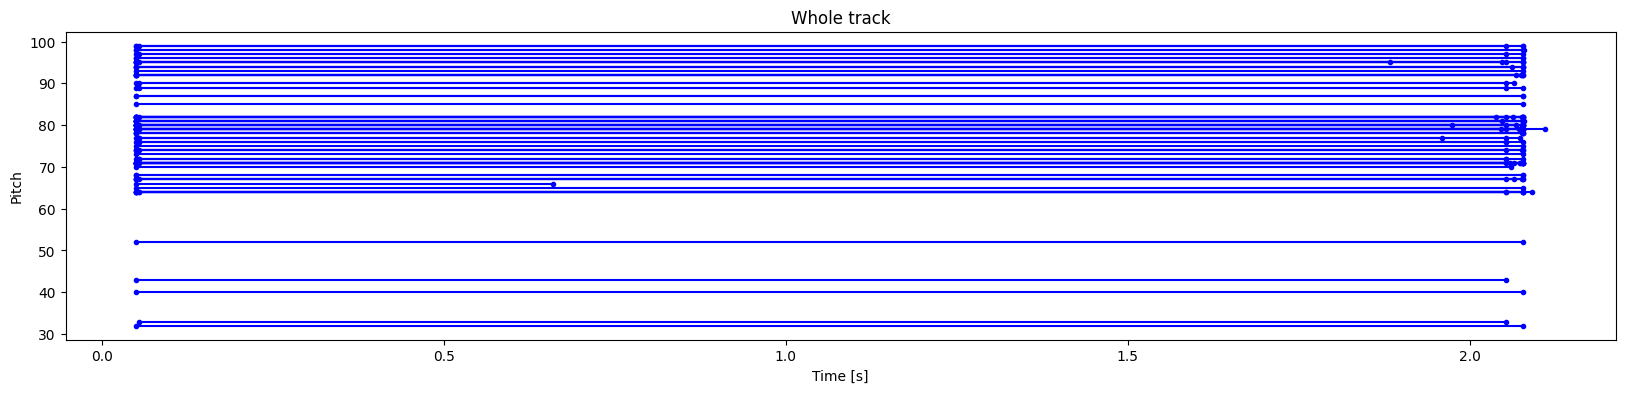

In [43]:
plot_piano_roll(generated_notes)

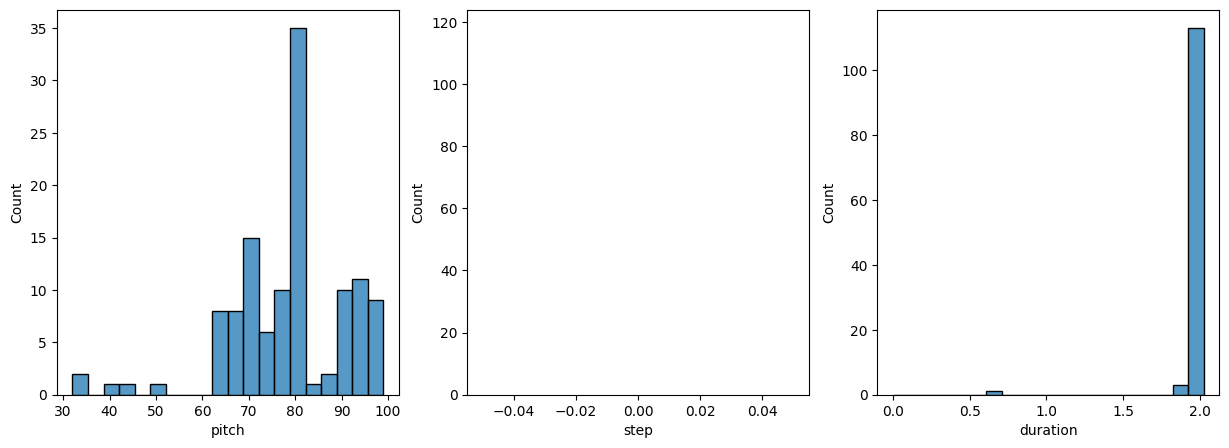

In [44]:
plot_distributions(generated_notes)